# Analysis for Low-dimensional Systems

@[Chaoming Wang](https://github.com/chaoming0625)

We have talked about model [simulation](../tutorial_simulation/index.rst) and [training](../tutorial_training/index.rst) for dynamical systems with BrainPy. In this section, we are going to dive into how to perform automatic analysis for your defined systems.  

As is known to us all, dynamics analysis is necessary in neurodynamics. This is because blind simulation of nonlinear systems is likely to produce few results or misleading results. BrainPy has well supports for low-dimensional systems, no matter how nonlinear your defined system is. Specifically, BrainPy provides the following methods for the analysis of low-dimensional systems:

1. phase plane analysis;
2. codimension 1 or codimension 2 bifurcation analysis;
3. bifurcation analysis of the fast-slow system. 

BrainPy will help you probe the dynamical mechanism of your defined systems rapidly. 

In [1]:
import brainpy as bp
import brainpy.math as bm

bp.math.set_platform('cpu')
bp.math.enable_x64()  # It's better to enable x64 when performing analysis

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## A simple case

Here we test BrainPy with a simple case:

$$
\frac{dx}{dt} = \mathrm{sin}(x) + I,
$$

where $x \in [-10, 10]$.

As known to us all, this functuon has multiple fixed points ($\frac{dx}{dt} = 0$) when $I=0$.

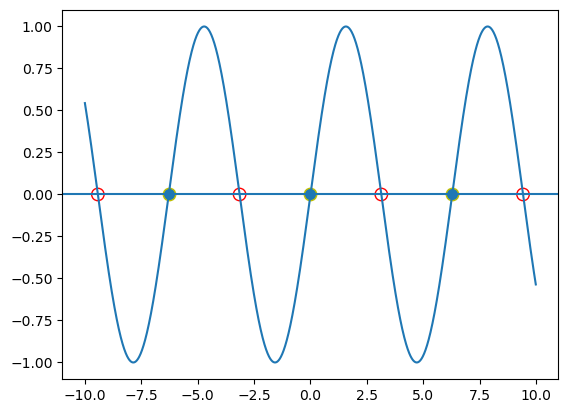

In [3]:
xs = np.arange(-10, 10, 0.01)

plt.plot(xs, np.sin(xs))
plt.scatter([-3*np.pi, -1*np.pi, 1*np.pi, 3 * np.pi], np.zeros(4), 
            s=80, facecolors='none', edgecolors='r')
plt.scatter([-2*np.pi, 0, 2*np.pi], np.zeros(3), s=80, edgecolors='y')
plt.axhline(0)
plt.show()

According to the dynamical theory, at the red hollow points, they are unstable; and for the solid ones, they are stable points. 

Now let's come back to BrainPy, and test whether BrainPy can give us the right answer. 

As the analysis interfaces in BrainPy only receives [ODEIntegrator](../apis/integrators/generated/brainpy.integrators.ODEIntegrator.rst) or instance of [DynamicalSystem](../apis/auto/simulation/generated/brainpy.simulation.brainobjects.DynamicalSystem.rst), we first define an integrator with BrainPy (if you want to know how to define an ODE integrator, please refer to the tutorial of [Numerical Solvers for ODEs](../tutorial_intg/ode_numerical_solvers.ipynb)):

In [4]:
@bp.odeint
def int_x(x, t, Iext):
    return bp.math.sin(x) + Iext

This is a one-dimensional dynamical system. So we are trying to use [brainpy.analysis.PhasePlane1D](../apis/auto/analysis/generated/brainpy.analysis.lowdim.PhasePlane1D.rst) for phase plane analysis. The usage of phase plane analysis  will be detailed in the following section. Now, we just focus on the following four arguments:

- **model**: It specifies the target system to analyze. It can be a list/tuple of [ODEIntegrator](../apis/integrators/generated/brainpy.integrators.ODEIntegrator.rst). However, it can also be an instance of [DynamicalSystem](../apis/auto/simulation/generated/brainpy.simulation.brainobjects.DynamicalSystem.rst). For ``DynamicalSystem`` argument, we will use ``model.ints().subset(bp.ode.ODEIntegrator)`` to retrieve all instances of ODEIntegrator later. 
- **target_vars**: It specifies the variables to analyze. It must be a dict with the format of ``<var_name, var_interval>``, where ``var_name`` is the variable name, and ``var_interval`` is the boundary of this variable. 
- **pars_update**: Parameters to update. 
- **resolutions**: The resolution to evaluate the fixed points. 

Let's try it.

I am creating vector fields ...
I am searching fixed points ...
Fixed point #1 at x=-9.42477796076938 is a unstable point.
Fixed point #2 at x=-6.283185307179586 is a stable point.
Fixed point #3 at x=-3.141592653589793 is a unstable point.
Fixed point #4 at x=9.237056486678452e-19 is a stable point.
Fixed point #5 at x=3.141592653589793 is a unstable point.
Fixed point #6 at x=6.283185307179586 is a stable point.
Fixed point #7 at x=9.42477796076938 is a unstable point.


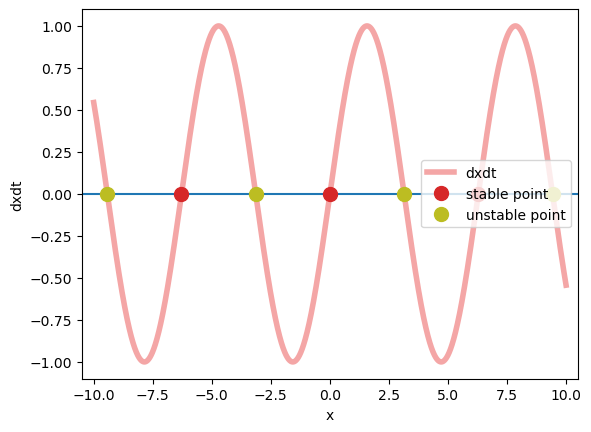

In [5]:
pp = bp.analysis.PhasePlane1D(
  model=int_x,
  target_vars={'x': [-10, 10]},
  pars_update={'Iext': 0.},
  resolutions=0.001
)
pp.plot_vector_field()
pp.plot_fixed_point(show=True)

Yeah, absolutelty, ``brainpy.analysis.PhasePlane1D`` gives us the right fixed points, and correctly evalutes the stability of these fixed points.  

Phase plane is important, because it give us the intuitive understanding how does the system evolve with the given parameters. However, in most cases, we care about how does the parameters affect the system behaviors. We should make bifurcation analysis. [brainpy.analysis.Bifurcation1D](../apis/auto/analysis/generated/brainpy.analysis.lowdim.Bifurcation1D.rst) is a convenient interface to help you rapidly get the insights of 1D system when the parameter changes. 

Similar to ``brainpy.analysis.PhasePlane1D``, ``brainpy.analysis.Bifurcation1D`` receives arguments like "model", "target_vars", "pars_update", and "resolutions". However, one more important argument **"target_pars"** should be provided. It specified the target parameter to make bifurcation analysis, with the setting of the parameter boundary.

Here, we systematically change the parameter "Iext" from 0 to 1.5. According to the bifurcation theory, we know this simple system has a fold bifurcation when $I=1.0$. Because at $I=1.0$, two fixed points collide with each other into a saddle point and then disappear. Does BrainPy's analysis toolkit ``brainpy.analysis.Bifurcation1D`` is capable of performing these analysis? Let's make a try.

I am making bifurcation analysis ...


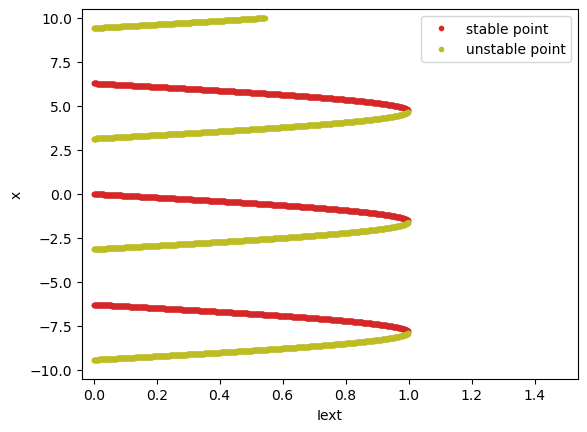

In [6]:
bif = bp.analysis.Bifurcation1D(
    model=int_x,
    target_vars={'x': [-10, 10]},
    target_pars={'Iext': [0., 1.5]},
    resolutions=0.001
)
bif.plot_bifurcation(show=True)

Once again, BrainPy analysis toolkit gives the right answer. It tells us how does the fixed points evolve when the parameter $I$ is increasing. 

It is worthy to note that bifurcation analysis in BrainPy is hard to find out the saddle point (when $I=0$ for this system). This is because the saddle point at the bifurcation just exists at a moment. While the numerical method used in BrainPy analysis toolkit is almost impossible to evaluate the point exactly at the saddle. However, if the user has the minimal knowledge about the bifurcation theory, saddle point (the collision point of two fixed points) can be easily infered from the fixed point evolution.

## A simplified inner mechanism

In order to understand the adavantages and disadvantages of BrainPy's analysis toolkit, it is better to know minimal mechanism how ``brainpy.analysis`` works.

The automatic model analysis in BrainPy heavily relies on numerical optimization method, including [Brent's method](https://en.wikipedia.org/wiki/Brent%27s_method) and [BFGS method](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm). For example, for the above one-dimensional system ($\frac{dx}{dt} = \mathrm{sin}(x) + I$), after the user sets the resolution to ``0.001``, we will get the evaluation points according to the variable boundary ``[-10, 10]``.

In [7]:
bp.math.arange(-10, 10, 0.001)

JaxArray(DeviceArray([-10.   ,  -9.999,  -9.998, ...,   9.997,   9.998,   9.999],            dtype=float64))

Then, BrainPy filters out the candidate intervals in which the roots lie in. Specifically, it tries to find all intervals like $[x_1, x_2]$ where $f(x_1) * f(x_2) \le 0$ for the 1D system $\frac{dx}{dt} = f(x)$. 

For example, the following two points which have opposite signs are candidate points we want. 

In [8]:
def plot_interval(x0, x1, f):
    xs = np.linspace(x0, x1, 100)
    plt.plot(xs, f(xs))
    plt.scatter([x0, x1], f(np.asarray([x0, x1])), edgecolors='r')
    plt.axhline(0)
    plt.show()

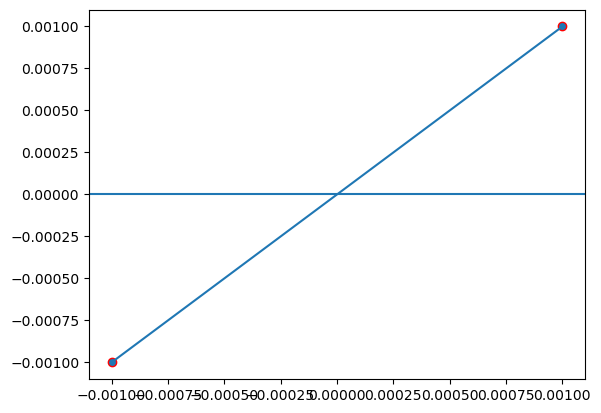

In [9]:
plot_interval(-0.001, 0.001, lambda x: np.sin(x))

According to the intermediate value theorem, there must be a solution between $x_1$ and $x_2$ when $f(x_1) * f(x_2) \le 0$. 

Based on these candidate intervals, BrainPy uses Brent's method to find roots $f(x) = 0$. Further, after obtain the value of the root, BrainPy uses automatic differentiation to evaluate the stability for each root solution. 

Overall, BrainPy's analysis toolkit show significant advantages and disadvantages.

**Pros**: BrainPy uses numerical methods to find roots and evaluate their stabilities, it does not case about how complex your function is. Therefore, it can apply to general problems, including any 1D and 2D dynamical systems, and some part of low-dimensional ($\ge 3$) dynamical systems (see later sections). Especially, BrainPy's analysis toolkit is highly useful when the mathematical equations are too complex to get analytical solutions. 

**Cons**: However, numerical optimization methods are hard to find fixed points only exist at a moment. Moreover, when ``resolution`` is small, there will be large amount of calculating. 

## Phase Plane Analysis

Phase plane analysis is one of the most important techniques for studying the behavior of nonlinear systems, since there is usually no analytical solution for a nonlinear system. BrainPy can help users to plot phase plane of 1D systems or 2D systems. Specifically, we provides [brainpy.analysis.PhasePlane1D](../apis/auto/analysis/generated/brainpy.analysis.lowdim.PhasePlane1D.rst) and [brainpy.analysis.PhasePlane2D](../apis/auto/analysis/generated/brainpy.analysis.lowdim.PhasePlane2D.rst). It can help to plot:

- **Nullcline**: The zero-growth isoclines, such as $g(x, y)=0$ and $g(x, y)=0$.
- **Fixed points**: The equilibrium points of the system, which are located at all of the nullclines intersect.
- **Vector filed**: The vector field of the system.
- **Limit cycles**: The limit cycles.
- **Trajectories**: A simulation trajectory with the given initial values.

**FitzHugh-Nagumo model**

Here, I will illustrate how to make phase plane analysis by using a well-known neuron model FitzHugh-Nagumo model. The FitzHugh-Nagumo model is given by:

$$ 
\frac {dV} {dt} = V(1 - \frac {V^2} 3) - w + I_{ext} \\
\tau \frac {dw} {dt} = V + a - b w 
$$

There are two variables $V$ and $w$, so this is a two-dimensional system with three parameters $a, b$ and $\tau$.

For the system to analyze, users can define it by using the pure ``brainpy.odeint`` or define it as a class of ``DynamicalSystem``. For this FitzHugh-Nagumo model, we define it as a class because later we will perform simulation to verify the analysis results. 

In [10]:
class FitzHughNagumoModel(bp.DynamicalSystem):
  def __init__(self, method='exp_auto'):
    super(FitzHughNagumoModel, self).__init__()

    # parameters
    self.a = 0.7
    self.b = 0.8
    self.tau = 12.5

    # variables
    self.V = bm.Variable(bm.zeros(1))
    self.w = bm.Variable(bm.zeros(1))
    self.Iext = bm.Variable(bm.zeros(1))

    # functions
    def dV(V, t, w, Iext=0.):
      dV = V - V * V * V / 3 - w + Iext
      return dV

    def dw(w, t, V, a=0.7, b=0.8):
      dw = (V + a - b * w) / self.tau
      return dw

    self.int_V = bp.odeint(dV, method=method)
    self.int_w = bp.odeint(dw, method=method)

  def update(self, _t, _dt):
    self.V.value = self.int_V(self.V, _t, self.w, self.Iext, _dt)
    self.w.value = self.int_w(self.w, _t, self.V, self.a, self.b, _dt)
    self.Iext[:] = 0.

In [11]:
model = FitzHughNagumoModel()

Here we perform a phase plane analysis with parameters $a=0.7, b=0.8, \tau=12.5$, and input $I_{ext} = 0.8$.

I am computing fx-nullcline ...
I am evaluating fx-nullcline by optimization ...
I am computing fy-nullcline ...
I am evaluating fy-nullcline by optimization ...
I am creating vector fields ...
I am searching fixed points ...
I am trying to find fixed points by optimization ...
	There are 866 candidates
I am trying to filter out duplicate fixed points ...
	Found 1 fixed points.
	#1 V=-0.2738719079879798, w=0.5329731346879486 is a unstable node.
I am plot trajectory ...


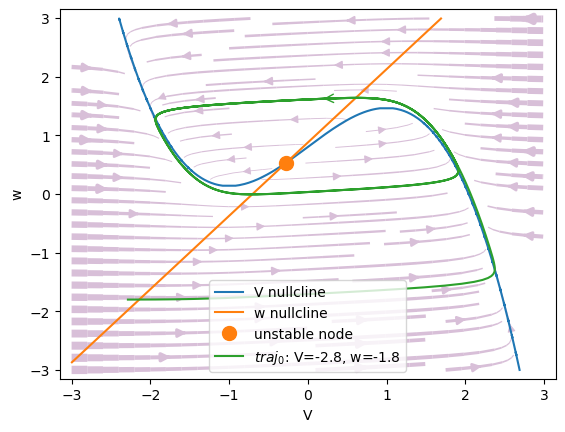

In [12]:
pp = bp.analysis.PhasePlane2D(
  model,
  target_vars={'V': [-3, 3], 'w': [-3., 3.]},
  pars_update={'Iext': 0.8}, 
  resolutions=0.01,
)

# By defaut, nullclines will be plotted as points, 
# while we can set the plot style as the line
pp.plot_nullcline(x_style={'fmt': '-'}, y_style={'fmt': '-'})

# Vector filed can plotted as two ways:
# - plot_method="streamplot" (default)
# - plot_method="quiver"
pp.plot_vector_field()

# There are many ways to search fixed points. 
# By default, it will use the nullcline points of the first 
# variable ("V") as the initial points to perform searching
pp.plot_fixed_point()

# Trajectory plotting receives the setting of the initial points.
# There may be multiple trajectories, therefore the initial points 
# should be provived as a list/tuple/numpy.ndarray/JaxArray
pp.plot_trajectory({'V': [-2.8], 'w': [-1.8]}, duration=100.)

# show the phase plane image
pp.show_figure()

We can see an unstable-node at the point (v=-0.27, w=0.53) inside a limit cycle. 

We can run a simulation with the same parameters and initial values to verify the periodic activity that correspond to the limit cycle.

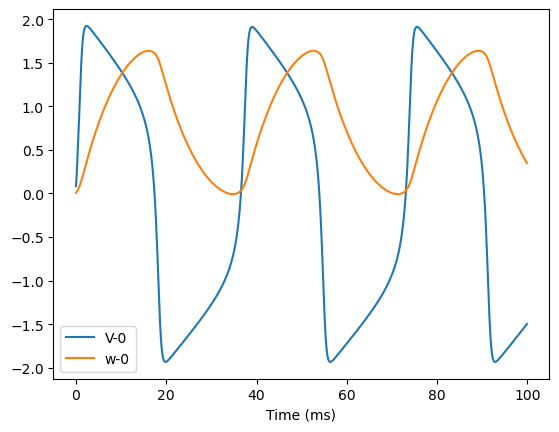

In [13]:
runner = bp.StructRunner(model, monitors=['V', 'w'], inputs=['Iext', 0.8])
runner.run(100.)

bp.visualize.line_plot(runner.mon.ts, runner.mon.V, legend='V')
bp.visualize.line_plot(runner.mon.ts, runner.mon.w, legend='w', show=True)

## Bifurcation Analysis

Nonlinear dynamical systems are characterized by its parameters. When the parameter changes, the system's behavior will change qualitatively. Therefore, we take care of how the system changes with the small smooth change of parameters. 

**Codimension 1 bifurcation analysis**

We will first see the codimension 1 bifurcation anlysis of the model. For example, we vary the input $I_{ext}$ between 0 to 1 and see how the system change it's stability.

I am making bifurcation analysis ...
I am filtering out fixed point candidates with auxiliary function ...
I am trying to find fixed points by optimization ...
	There are 5000 candidates
I am trying to filter out duplicate fixed points ...
	Found 522 fixed points.


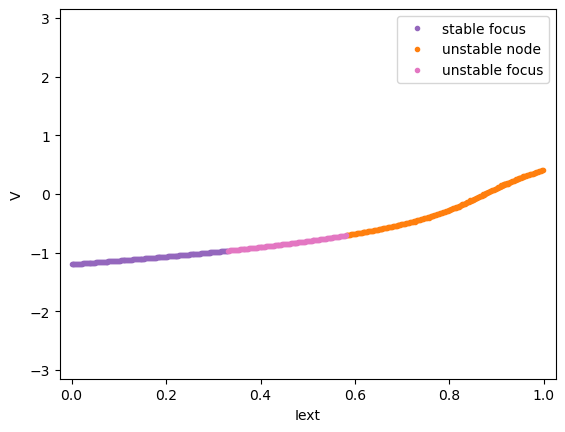

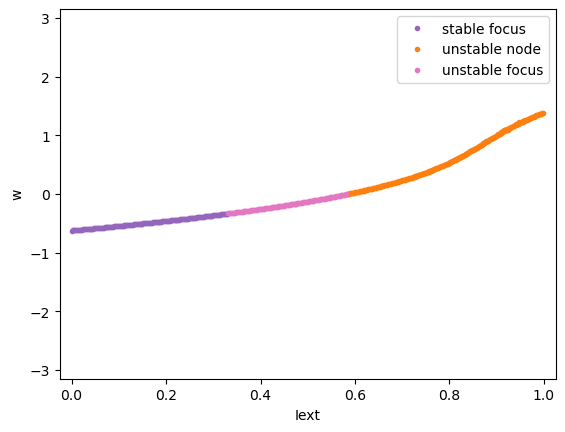

In [18]:
analyzer = bp.analysis.Bifurcation2D(
  model,
  target_pars={'Iext': [0., 1.]},
  target_vars={'V': [-3, 3], 'w': [-3., 3.]},
  resolutions={'Iext': 0.002},
)
analyzer.plot_bifurcation(num_rank=10)
analyzer.show_figure()

**Codimension 2 bifurcation analysis**

We simulaneously change $I_{ext}$ and parameter $a$.

I am making bifurcation analysis ...
I am filtering out fixed point candidates with auxiliary function ...
I am trying to find fixed points by optimization ...
	There are 50000 candidates
I am trying to filter out duplicate fixed points ...
	Found 5099 fixed points.


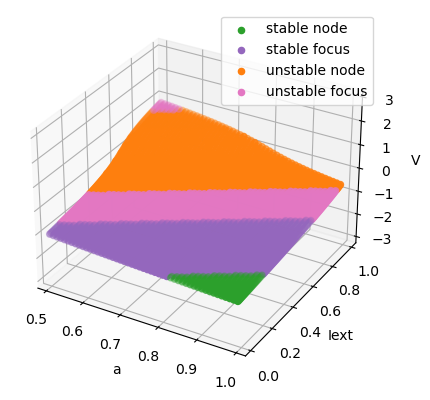

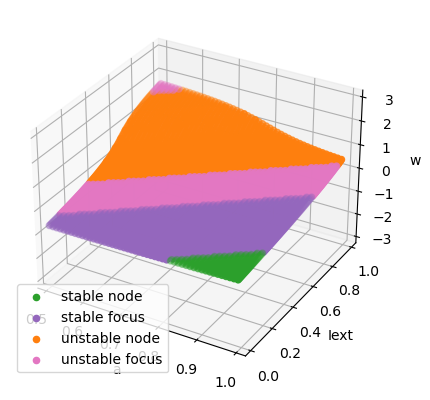

In [19]:
analyzer = bp.analysis.Bifurcation2D(
    model,
    target_vars=dict(V=[-3, 3], w=[-3., 3.]),
    target_pars=dict(a=[0.5, 1.], Iext=[0., 1.]),
    resolutions={'a': 0.01, 'Iext': 0.01},
)
analyzer.plot_bifurcation(num_rank=10)
analyzer.show_figure()

## Fast-Slow System Bifurcation

BrainPy also provides a tool for fast-slow system bifurcation analysis by using [brainpy.analysis.FastSlow1D](../apis/auto/analysis/generated/brainpy.analysis.lowdim.FastSlow1D.rst) and [brainpy.analysis.FastSlow2D](../apis/auto/analysis/generated/brainpy.analysis.lowdim.FastSlow2D.rst). This method is proposed by John Rinzel [1, 2, 3]. (J Rinzel, 1985, 1986, 1987) proposed that in a fast-slow dynamical system, we can treat the slow variables as the bifurcation parameters, and then study how the different value of slow variables affect the bifurcation of the fast sub-system.


Fast-slow bifurcation methods are very usefull in the bursting neuron analysis. I will illustrate this by using the Hindmarsh-Rose model. The Hindmarsh–Rose model of neuronal activity is aimed to study the spiking-bursting behavior of the membrane potential observed in experiments made with a single neuron. Its dynamics are governed by:

$$
\begin{aligned}
\frac{d V}{d t} &= y - a V^3 + b V^2 - z + I\\
\frac{d y}{d t} &= c - d V^2 - y\\
\frac{d z}{d t} &= r (s (V - V_{rest}) - z)
\end{aligned}
$$

First of all, let's define the Hindmarsh–Rose model with BrainPy. 

In [16]:
a = 1.
b = 3.
c = 1.
d = 5.
s = 4.
x_r = -1.6
r = 0.001
Vth = 1.9


@bp.odeint
def int_x(x, t, y, z, Isyn):
    return y - a * x ** 3 + b * x * x - z + Isyn

@bp.odeint
def int_y(y, t, x):
    return c - d * x * x - y

@bp.odeint
def int_z(z, t, x):
    return r * (s * (x - x_r) - z)

We now can start to analysis the underlying bifurcation mechanism.

I am making bifurcation analysis ...
I am filtering out fixed point candidates with auxiliary function ...
I am trying to find fixed points by optimization ...
	There are 20000 candidates
I am trying to filter out duplicate fixed points ...
	Found 1232 fixed points.


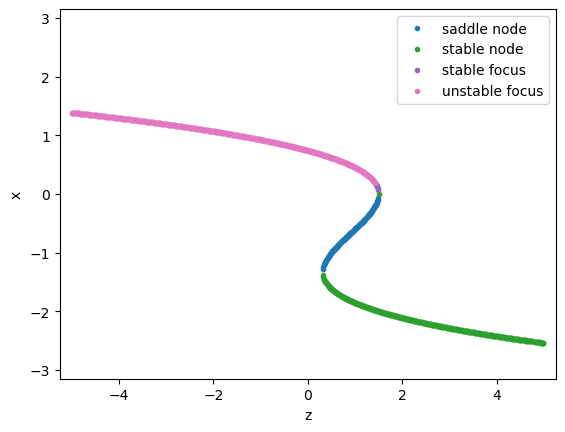

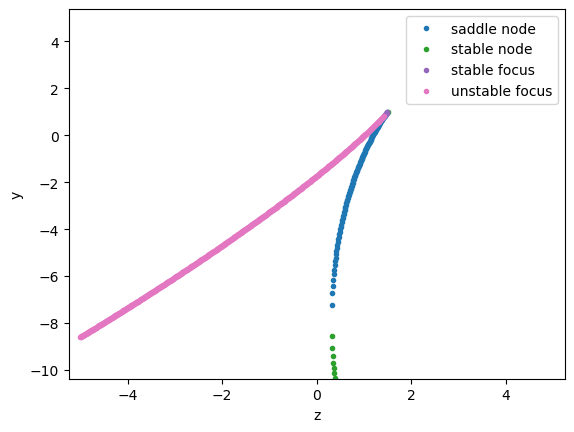

In [17]:
analyzer = bp.analysis.FastSlow2D(
  [int_x, int_y, int_z],
  fast_vars={'x': [-3, 3], 'y': [-10., 5.]},
  slow_vars={'z': [-5., 5.]},
  pars_update={'Isyn': 0.5},
  resolutions={'z': 0.01}
)
analyzer.plot_bifurcation(num_rank=20)
analyzer.show_figure()

**References**:

[1] Rinzel, John. "Bursting oscillations in an excitable membrane model." In Ordinary and partial differential  equations, pp. 304-316. Springer, Berlin, Heidelberg, 1985.
           
[2] Rinzel, John , and Y. S. Lee . On Different Mechanisms for Membrane Potential Bursting. Nonlinear Oscillations in Biology and Chemistry. Springer Berlin Heidelberg, 1986.

[3] Rinzel, John. "A formal classification of bursting mechanisms in excitable systems." In Mathematical topics in population biology, morphogenesis and neurosciences, pp. 267-281. Springer, Berlin, Heidelberg, 1987.
